In [1]:
# Need 70Gb memory to run this as peaks at just over 60gb RAM

In [2]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from useful_funcs import parse_data_dfs, make_timeseries
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import sys

di_df, pi_df, ti_df, dp_df, pp_df, tp_df = parse_data_dfs()
imperfect_final_rivs, perfect_final_rivs = list(di_df), list(dp_df)

print('Collected all base dataframes')
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

dtrain_df = di_df.loc[:, train_rivs]
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]

print('Transforming dataframes into timeseries dataframe')
data_days = 49
future_days = 14
rivers_to_consider = 1816  # up to 1816 rivers but will be slower


def slide_window_riv(riv):
    rolling_period = data_days+future_days
    imp = riv in list(di_df)
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []

    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        # https://stats.stackexchange.com/questions/35304/how-to-standardize-an-array-if-standard-deviation-is-zero
        rd_d = rd.values[:data_days]
        # rd_m, rd_std = np.mean(rd_d), np.std(rd_d) if np.std(rd_d) != 0 else 1
        rd_min, rd_max = np.min(rd_d), np.max(rd_d)
        rd_denom = (rd_max - rd_min) if (rd_max - rd_min) != 0 else 1

        rp_d = rp.values[:data_days]
        # rp_m, rp_std = np.mean(rp_d), np.std(rp_d) if np.std(rp_d) != 0 else 1
        rp_min, rp_max = np.min(rp_d), np.max(rp_d)
        rp_denom = (rp_max - rp_min) if (rp_max - rp_min) != 0 else 1

        rt_d = rt.values[:data_days]
        # rt_m, rt_std = np.mean(rt_d), np.std(rt_d) if np.std(rt_d) != 0 else 1
        rt_min, rt_max = np.min(rt_d), np.max(rt_d)
        rt_denom = (rt_max - rt_min) if (rt_max - rt_min) != 0 else 1

        feature_data = np.concatenate((rd_d, rp_d, rt_d))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_m)/rd_std, (rp_d-rp_m)/rp_std, (rt_d-rt_m)/rt_std))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_min)/rd_denom, (rp_d-rp_min)/rp_denom, (rt_d-rt_min)/rt_denom))
        features = [rd.values[-1], riv, idx] + list(feature_data)
        # features = [(rd.values[-1]-rd_min)/rd_denom, riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


all_rivs = list(di_df) + list(dp_df)
X_train_df, X_val_df, X_test_df = make_timeseries(
    all_rivs[:rivers_to_consider], train_rivs, validate_rivs, slide_window_riv, data_days)
X_train_df['year_sin'] = np.sin(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_train_df['year_cos'] = np.cos(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_sin'] = np.sin(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_cos'] = np.cos(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_sin'] = np.sin(X_test_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_cos'] = np.cos(X_test_df['river_day'] * (2 * np.pi / 365.2425))


2022-11-16 02:29:02.586248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 02:29:02.650100: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Collected all base dataframes
Transforming dataframes into timeseries dataframe


Reassigning river data to correct frame: 100%|██████████| 1816/1816 [00:58<00:00, 30.80it/s]


Training data made
Training data sorted
Validation data made
Validation data sorted
Test data made
Test data sorted


In [3]:
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

tot_size = sizeof_fmt(sum([sys.getsizeof(value) for name, value in globals().items()]))
print(f'Current total size of variables is {tot_size} ... who knows what rest is!')
# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Current total size of variables is 8.0 GiB ... who knows what rest is!


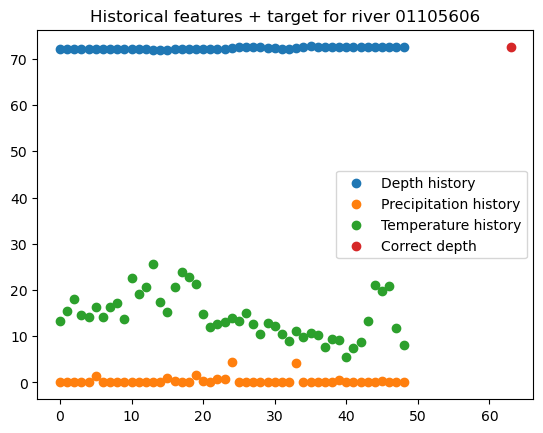

In [4]:
# What input and prediction looks like looks like
rowIdx = 42
y_point = X_train_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_train_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_train_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_train_df.iloc[rowIdx, :][all_ts].to_list()
plt.scatter(range(data_days), d_points, label='Depth history')
plt.scatter(range(data_days), p_points, label='Precipitation history')
plt.scatter(range(data_days), t_points, label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.legend()
riv_name = X_train_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.show()


In [5]:
# Baseline model
model = Sequential([
    Dense(1, input_shape=np.array(X_val_df.columns[3:]).shape)
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=200,
                    batch_size=10000,
                    validation_split=0.2)


2022-11-16 02:39:47.511992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
343/343 [==============================] - 3s 7ms/step - loss: 15.1367 - mean_absolute_error: 2.8045 - val_loss: 7.1674 - val_mean_absolute_error: 1.8743
Epoch 2/200
343/343 [==============================] - 1s 2ms/step - loss: 7.3426 - mean_absolute_error: 1.8451 - val_loss: 4.6283 - val_mean_absolute_error: 1.3913
Epoch 3/200
343/343 [==============================] - 1s 2ms/step - loss: 5.3895 - mean_absolute_error: 1.4699 - val_loss: 3.6405 - val_mean_absolute_error: 1.1410
Epoch 4/200
343/343 [==============================] - 1s 2ms/step - loss: 4.6297 - mean_absolute_error: 1.2796 - val_loss: 3.2109 - val_mean_absolute_error: 0.9973
Epoch 5/200
343/343 [==============================] - 1s 2ms/step - loss: 4.2849 - mean_absolute_error: 1.1748 - val_loss: 3.0146 - val_mean_absolute_error: 0.9199
Epoch 6/200
343/343 [==============================] - 1s 2ms/step - loss: 4.1070 - mean_absolute_error: 1.1129 - val_loss: 2.9201 - val_mean_absolute_error: 0.8662
Epoch 7/2

343/343 [==============================] - 1s 2ms/step - loss: 3.7364 - mean_absolute_error: 0.9684 - val_loss: 2.6321 - val_mean_absolute_error: 0.7327
Epoch 51/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7385 - mean_absolute_error: 0.9692 - val_loss: 2.6544 - val_mean_absolute_error: 0.7464
Epoch 52/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7364 - mean_absolute_error: 0.9686 - val_loss: 2.6402 - val_mean_absolute_error: 0.7543
Epoch 53/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7364 - mean_absolute_error: 0.9686 - val_loss: 2.6443 - val_mean_absolute_error: 0.7515
Epoch 54/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7374 - mean_absolute_error: 0.9689 - val_loss: 2.6353 - val_mean_absolute_error: 0.7267
Epoch 55/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7354 - mean_absolute_error: 0.9681 - val_loss: 2.8220 - val_mean_absolute_error: 0.7659
Epoch 56/200
343/

343/343 [==============================] - 1s 2ms/step - loss: 3.7290 - mean_absolute_error: 0.9659 - val_loss: 2.6409 - val_mean_absolute_error: 0.7430
Epoch 100/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7314 - mean_absolute_error: 0.9675 - val_loss: 2.7172 - val_mean_absolute_error: 0.7940
Epoch 101/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7338 - mean_absolute_error: 0.9688 - val_loss: 2.6595 - val_mean_absolute_error: 0.7782
Epoch 102/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7333 - mean_absolute_error: 0.9682 - val_loss: 2.6484 - val_mean_absolute_error: 0.7128
Epoch 103/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7303 - mean_absolute_error: 0.9671 - val_loss: 2.6436 - val_mean_absolute_error: 0.7561
Epoch 104/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7276 - mean_absolute_error: 0.9653 - val_loss: 2.6231 - val_mean_absolute_error: 0.7317
Epoch 105/20

343/343 [==============================] - 1s 2ms/step - loss: 3.7270 - mean_absolute_error: 0.9657 - val_loss: 2.6313 - val_mean_absolute_error: 0.7208
Epoch 149/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7301 - mean_absolute_error: 0.9672 - val_loss: 2.6195 - val_mean_absolute_error: 0.7237
Epoch 150/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7286 - mean_absolute_error: 0.9664 - val_loss: 2.6331 - val_mean_absolute_error: 0.7504
Epoch 151/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7265 - mean_absolute_error: 0.9653 - val_loss: 2.6608 - val_mean_absolute_error: 0.7278
Epoch 152/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7314 - mean_absolute_error: 0.9682 - val_loss: 2.6462 - val_mean_absolute_error: 0.7687
Epoch 153/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7273 - mean_absolute_error: 0.9655 - val_loss: 2.6511 - val_mean_absolute_error: 0.7569
Epoch 154/20

343/343 [==============================] - 1s 2ms/step - loss: 3.7271 - mean_absolute_error: 0.9656 - val_loss: 2.6316 - val_mean_absolute_error: 0.7460
Epoch 198/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7254 - mean_absolute_error: 0.9648 - val_loss: 2.6469 - val_mean_absolute_error: 0.7192
Epoch 199/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7311 - mean_absolute_error: 0.9675 - val_loss: 2.6205 - val_mean_absolute_error: 0.7294
Epoch 200/200
343/343 [==============================] - 1s 2ms/step - loss: 3.7291 - mean_absolute_error: 0.9668 - val_loss: 2.6886 - val_mean_absolute_error: 0.8182


Really poor performance


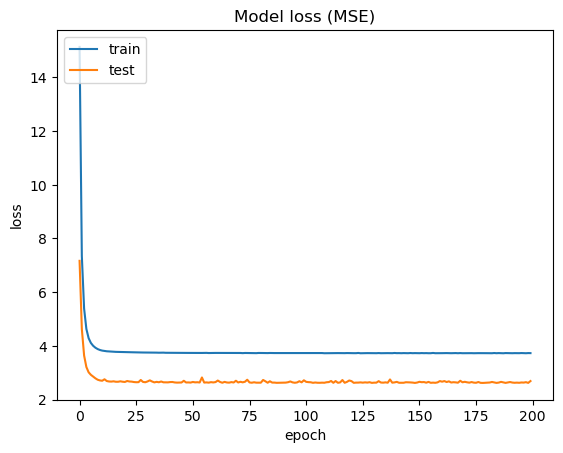

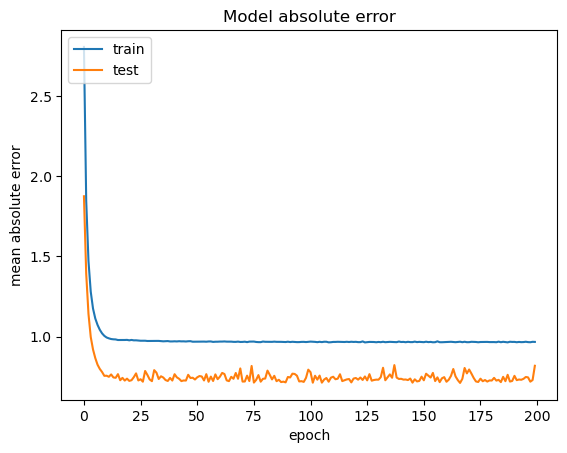

In [6]:
print('Really poor performance')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


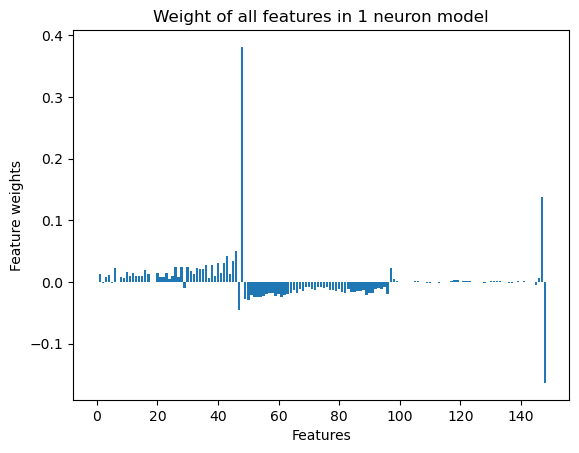

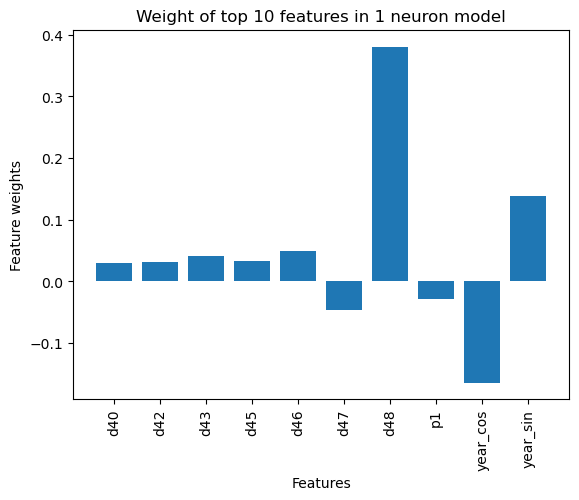

In [7]:
# based on https://www.tensorflow.org/tutorials/structured_data/time_series
cols = list(X_val_df)[3:]
plt.bar(x=range(len(cols)),
        height=model.layers[0].kernel[:, 0].numpy())
plt.title('Weight of all features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()

# top 10 features
top_num = 10
basic_coef_ord = np.argsort(np.absolute(model.layers[0].kernel[:, 0].numpy()))
new_cols = []
for idx in basic_coef_ord[-top_num:][::-1]:
    col_name = cols[idx]
    col_val = model.layers[0].kernel[:, 0].numpy()[idx]
    new_cols.append((col_name, col_val))
new_cols.sort(key=lambda x: x[0])
plt.bar(x=range(top_num),
        height=[b for a, b in new_cols])
axis = plt.gca()
axis.set_xticks(range(top_num))
_ = axis.set_xticklabels([a for a, b in new_cols], rotation=90)
plt.title(f'Weight of top {top_num} features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()


In [8]:
gc.collect()

146

In [9]:
complex_model_2 = Sequential([
    # dense layer 1
#     tf.keras.layers.Conv1D(32, 4, activation='relu',input_shape=np.array(X_val_df.columns[3:]).shape),
    Dense(units=100, activation='relu'),
    Dense(units=100, activation='relu'),
    Dense(units=100, activation='relu'),
    Dense(1)
])
complex_model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

complex_history_2 = complex_model_2.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=300,
                    batch_size=20000,
                    validation_split=0.2, verbose=1)

Epoch 1/300
172/172 [==============================] - 4s 20ms/step - loss: 19.7661 - mean_absolute_error: 1.5603 - val_loss: 2.8035 - val_mean_absolute_error: 0.8177
Epoch 2/300
172/172 [==============================] - 2s 14ms/step - loss: 3.8063 - mean_absolute_error: 1.0119 - val_loss: 2.6862 - val_mean_absolute_error: 0.7657
Epoch 3/300
172/172 [==============================] - 2s 14ms/step - loss: 3.6946 - mean_absolute_error: 0.9910 - val_loss: 2.6836 - val_mean_absolute_error: 0.7635
Epoch 4/300
172/172 [==============================] - 2s 14ms/step - loss: 3.6229 - mean_absolute_error: 0.9766 - val_loss: 2.6440 - val_mean_absolute_error: 0.7846
Epoch 5/300
172/172 [==============================] - 2s 14ms/step - loss: 3.5762 - mean_absolute_error: 0.9715 - val_loss: 2.6858 - val_mean_absolute_error: 0.8074
Epoch 6/300
172/172 [==============================] - 2s 14ms/step - loss: 3.5308 - mean_absolute_error: 0.9664 - val_loss: 2.8089 - val_mean_absolute_error: 0.8746
Epo

172/172 [==============================] - 2s 14ms/step - loss: 3.0705 - mean_absolute_error: 0.9046 - val_loss: 2.6848 - val_mean_absolute_error: 0.7514
Epoch 51/300
172/172 [==============================] - 2s 14ms/step - loss: 3.0651 - mean_absolute_error: 0.9068 - val_loss: 2.6781 - val_mean_absolute_error: 0.8338
Epoch 52/300
172/172 [==============================] - 2s 14ms/step - loss: 3.0481 - mean_absolute_error: 0.9025 - val_loss: 2.7107 - val_mean_absolute_error: 0.8606
Epoch 53/300
172/172 [==============================] - 2s 14ms/step - loss: 3.0501 - mean_absolute_error: 0.9073 - val_loss: 2.6958 - val_mean_absolute_error: 0.8149
Epoch 54/300
172/172 [==============================] - 2s 14ms/step - loss: 3.0216 - mean_absolute_error: 0.8996 - val_loss: 2.6506 - val_mean_absolute_error: 0.7765
Epoch 55/300
172/172 [==============================] - 2s 14ms/step - loss: 2.9903 - mean_absolute_error: 0.8924 - val_loss: 2.6669 - val_mean_absolute_error: 0.8067
Epoch 56/30

172/172 [==============================] - 2s 14ms/step - loss: 2.6333 - mean_absolute_error: 0.8579 - val_loss: 2.6884 - val_mean_absolute_error: 0.7693
Epoch 100/300
172/172 [==============================] - 2s 14ms/step - loss: 2.6021 - mean_absolute_error: 0.8473 - val_loss: 2.6714 - val_mean_absolute_error: 0.7935
Epoch 101/300
172/172 [==============================] - 2s 14ms/step - loss: 2.5911 - mean_absolute_error: 0.8450 - val_loss: 2.6506 - val_mean_absolute_error: 0.7943
Epoch 102/300
172/172 [==============================] - 2s 14ms/step - loss: 2.5846 - mean_absolute_error: 0.8443 - val_loss: 2.7604 - val_mean_absolute_error: 0.7930
Epoch 103/300
172/172 [==============================] - 2s 14ms/step - loss: 2.5884 - mean_absolute_error: 0.8479 - val_loss: 2.7225 - val_mean_absolute_error: 0.7676
Epoch 104/300
172/172 [==============================] - 2s 14ms/step - loss: 2.5657 - mean_absolute_error: 0.8407 - val_loss: 2.7273 - val_mean_absolute_error: 0.7538
Epoch 

Epoch 148/300
172/172 [==============================] - 2s 14ms/step - loss: 2.4118 - mean_absolute_error: 0.8255 - val_loss: 2.6918 - val_mean_absolute_error: 0.7726
Epoch 149/300
172/172 [==============================] - 2s 14ms/step - loss: 2.4060 - mean_absolute_error: 0.8229 - val_loss: 2.6947 - val_mean_absolute_error: 0.7759
Epoch 150/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3937 - mean_absolute_error: 0.8192 - val_loss: 2.6674 - val_mean_absolute_error: 0.7597
Epoch 151/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3963 - mean_absolute_error: 0.8213 - val_loss: 2.6712 - val_mean_absolute_error: 0.7960
Epoch 152/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3988 - mean_absolute_error: 0.8244 - val_loss: 2.6850 - val_mean_absolute_error: 0.7926
Epoch 153/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3905 - mean_absolute_error: 0.8204 - val_loss: 2.7063 - val_mean_absolute_error:

Epoch 197/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2987 - mean_absolute_error: 0.8086 - val_loss: 2.6882 - val_mean_absolute_error: 0.7735
Epoch 198/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3110 - mean_absolute_error: 0.8126 - val_loss: 2.7130 - val_mean_absolute_error: 0.7582
Epoch 199/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3056 - mean_absolute_error: 0.8111 - val_loss: 2.6669 - val_mean_absolute_error: 0.7844
Epoch 200/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2967 - mean_absolute_error: 0.8095 - val_loss: 2.7054 - val_mean_absolute_error: 0.7665
Epoch 201/300
172/172 [==============================] - 2s 14ms/step - loss: 2.3028 - mean_absolute_error: 0.8114 - val_loss: 2.6805 - val_mean_absolute_error: 0.7605
Epoch 202/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2931 - mean_absolute_error: 0.8089 - val_loss: 2.6582 - val_mean_absolute_error:

Epoch 246/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2345 - mean_absolute_error: 0.8001 - val_loss: 2.7091 - val_mean_absolute_error: 0.7568
Epoch 247/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2355 - mean_absolute_error: 0.8002 - val_loss: 2.8134 - val_mean_absolute_error: 0.8286
Epoch 248/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2325 - mean_absolute_error: 0.8005 - val_loss: 2.6743 - val_mean_absolute_error: 0.7560
Epoch 249/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2405 - mean_absolute_error: 0.8023 - val_loss: 2.7594 - val_mean_absolute_error: 0.7697
Epoch 250/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2363 - mean_absolute_error: 0.8012 - val_loss: 2.7093 - val_mean_absolute_error: 0.8026
Epoch 251/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2324 - mean_absolute_error: 0.8008 - val_loss: 2.7489 - val_mean_absolute_error:

Epoch 295/300
172/172 [==============================] - 2s 14ms/step - loss: 2.2024 - mean_absolute_error: 0.7983 - val_loss: 2.7554 - val_mean_absolute_error: 0.7621
Epoch 296/300
172/172 [==============================] - 2s 14ms/step - loss: 2.1865 - mean_absolute_error: 0.7946 - val_loss: 2.7797 - val_mean_absolute_error: 0.7724
Epoch 297/300
172/172 [==============================] - 2s 14ms/step - loss: 2.1882 - mean_absolute_error: 0.7960 - val_loss: 2.7536 - val_mean_absolute_error: 0.8073
Epoch 298/300
172/172 [==============================] - 2s 14ms/step - loss: 2.1862 - mean_absolute_error: 0.7941 - val_loss: 2.7296 - val_mean_absolute_error: 0.7831
Epoch 299/300
172/172 [==============================] - 2s 14ms/step - loss: 2.1872 - mean_absolute_error: 0.7948 - val_loss: 2.7334 - val_mean_absolute_error: 0.8039
Epoch 300/300
172/172 [==============================] - 2s 14ms/step - loss: 2.1917 - mean_absolute_error: 0.7967 - val_loss: 2.8496 - val_mean_absolute_error:

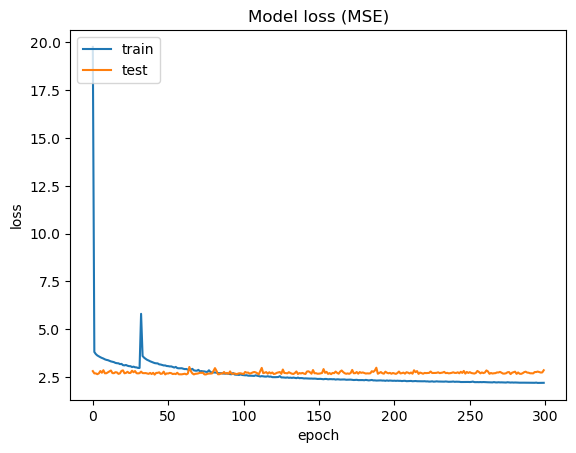

In [10]:
plt.plot(complex_history_2.history['loss'])
plt.plot(complex_history_2.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 1ms/step


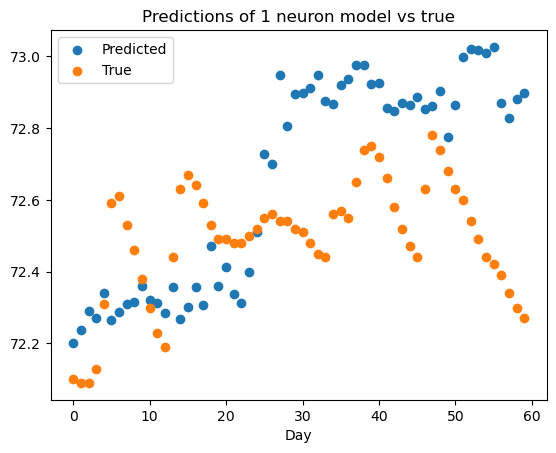

2/2 [==============================] - 0s 1ms/step


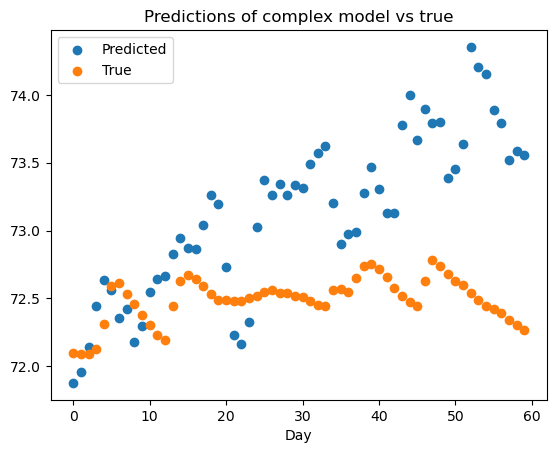

In [11]:
points = 60
df = X_train_df

predictions = model.predict(x=df.iloc[:points, 3:], workers=16, use_multiprocessing=True).reshape(-1)
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of 1 neuron model vs true')
plt.xlabel('Day')
plt.show()

predictions = complex_model_2.predict(x=df.iloc[:points, 3:], workers=16, use_multiprocessing=True).reshape(-1)
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of complex model vs true')
plt.xlabel('Day')
plt.show()

In [12]:
np.argmax(X_train_df.iloc[:, 0])

4248857

In [13]:
np.max(X_train_df.iloc[:, 0])

714.61

In [14]:
X_train_df.iloc[612495,:]

y                 3.8
river        02169000
river_day        1917
d0               2.48
d1               2.86
               ...   
t46             18.35
t47             20.55
t48              18.6
year_sin      0.99996
year_cos     0.008999
Name: 1844551, Length: 152, dtype: object

In [15]:
X_train_df.iloc[612495-2:612495+2,:]

,y,river,river_day,d0,d1,d2,d3,d4,d5,d6,...,t41,t42,t43,t44,t45,t46,t47,t48,year_sin,year_cos
1844549,3.87,02169000,1915,2.26,2.27,2.48,2.86,2.36,2.31,2.30,...,21.35,22.20,22.20,18.60,19.75,20.30,19.45,18.35,0.999058,0.043391
1844550,3.58,02169000,1916,2.27,2.48,2.86,2.36,2.31,2.30,2.28,...,22.20,22.20,18.60,19.75,20.30,19.45,18.35,20.55,0.999657,0.026199
1844551,3.80,02169000,1917,2.48,2.86,2.36,2.31,2.30,2.28,3.54,...,22.20,18.60,19.75,20.30,19.45,18.35,20.55,18.60,0.999960,0.008999
1844552,4.37,02169000,1918,2.86,2.36,2.31,2.30,2.28,3.54,2.44,...,18.60,19.75,20.30,19.45,18.35,20.55,18.60,13.60,0.999966,-0.008203


In [16]:
X_train_df.iloc[335593-2:335593+2,:]

,y,river,river_day,d0,d1,d2,d3,d4,d5,d6,...,t41,t42,t43,t44,t45,t46,t47,t48,year_sin,year_cos
3981471,0.66,02114450,1597,0.68,1.01,0.79,0.69,0.66,0.64,0.64,...,10.00,16.40,9.75,5.85,2.25,0.55,3.60,7.75,0.718400,-0.695631
3981472,0.67,02114450,1598,1.01,0.79,0.69,0.66,0.64,0.64,0.65,...,16.40,9.75,5.85,2.25,0.55,3.60,7.75,11.15,0.706327,-0.707886
3981473,0.66,02114450,1599,0.79,0.69,0.66,0.64,0.64,0.65,0.65,...,9.75,5.85,2.25,0.55,3.60,7.75,11.15,5.00,0.694046,-0.719931
3981474,0.65,02114450,1600,0.69,0.66,0.64,0.64,0.65,0.65,0.64,...,5.85,2.25,0.55,3.60,7.75,11.15,5.00,6.70,0.681559,-0.731763


In [17]:
rd_d = X_train_df.iloc[335593,3:3+49].to_numpy()
rd_min, rd_max = np.min(rd_d), np.max(rd_d)